In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
from google.colab import files
uploaded = files.upload()


Saving AAPL.csv to AAPL.csv


In [25]:
import io
  
df = pd.read_csv(io.BytesIO(uploaded['AAPL.csv']),index_col='Date',parse_dates=True)
print(df.head())

                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2015-01-02  27.847500  27.860001  26.837500  27.332500  24.819241  212818400
2015-01-05  27.072500  27.162500  26.352501  26.562500  24.120045  257142000
2015-01-06  26.635000  26.857500  26.157499  26.565001  24.122320  263188400
2015-01-07  26.799999  27.049999  26.674999  26.937500  24.460564  160423600
2015-01-08  27.307501  28.037500  27.174999  27.972500  25.400398  237458000


Text(0.5, 1.0, 'Plotting Moving Average')

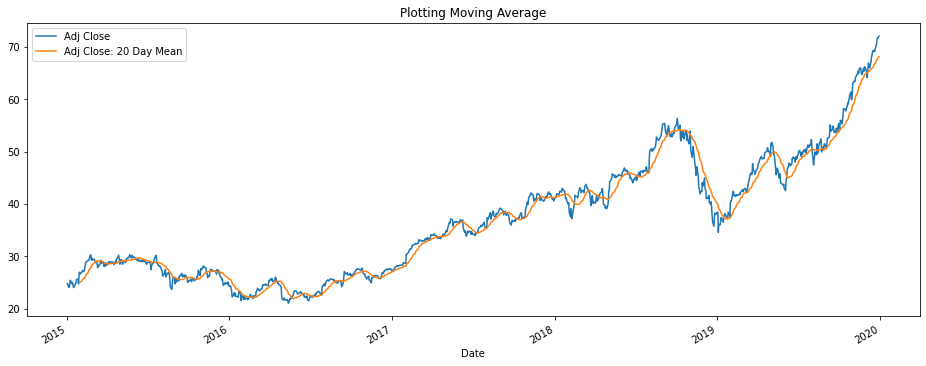

In [26]:
#Plotting Moving Average

df['Adj Close: 20 Day Mean']=df['Adj Close'].rolling(window=20).mean()
df[['Adj Close','Adj Close: 20 Day Mean']].plot(figsize=(16,6))
plt.title('Plotting Moving Average')

Text(0.5, 1.0, 'Plotting Exponentially Weighted Moving Average')

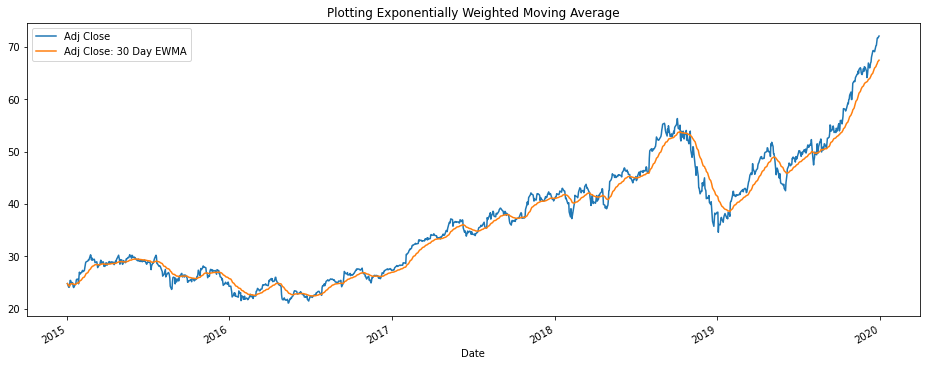

In [27]:
#Plotting Exponentially Weighted Moving Average
#No lag, more weight on recent values

df['Adj Close: 30 Day EWMA']=df['Adj Close'].ewm(span=30).mean()
df[['Adj Close','Adj Close: 30 Day EWMA']].plot(figsize=(16,6))
plt.title('Plotting Exponentially Weighted Moving Average')

Text(0.5, 1.0, 'Bollinger Bands')

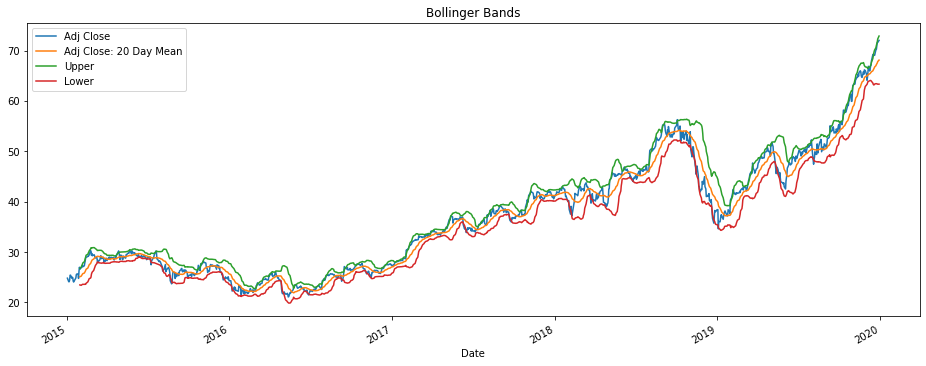

In [28]:
#Plotting Bollinger Bands

df['Adj Close: 20 Day Mean']=df['Adj Close'].rolling(window=20).mean()
df['Upper'] = df['Adj Close: 20 Day Mean'] + 2*df['Adj Close'].rolling(window=20).std()
df['Lower'] = df['Adj Close: 20 Day Mean'] - 2*df['Adj Close'].rolling(window=20).std()
df[['Adj Close','Adj Close: 20 Day Mean','Upper','Lower']].plot(figsize=(16,6))
plt.title('Bollinger Bands')

In [29]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [54]:
#First, we need to check if a series is stationary or not using Augmented Dickey Fuller Test 
#because time series analysis only works with stationary data.

def test_stationarity(timeseries):
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # dft will output without defining what the values are.
    # hence we manually write what values it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    
    print(output)
    
test_stationarity(df['Adj Close'])

Results of dickey fuller test
Test Statistics                   1.038281
p-value                           0.994654
No. of lags used                  9.000000
Number of observations used    1247.000000
dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  This is separate from the ipykernel package so we can avoid doing imports until


<Figure size 432x288 with 0 Axes>

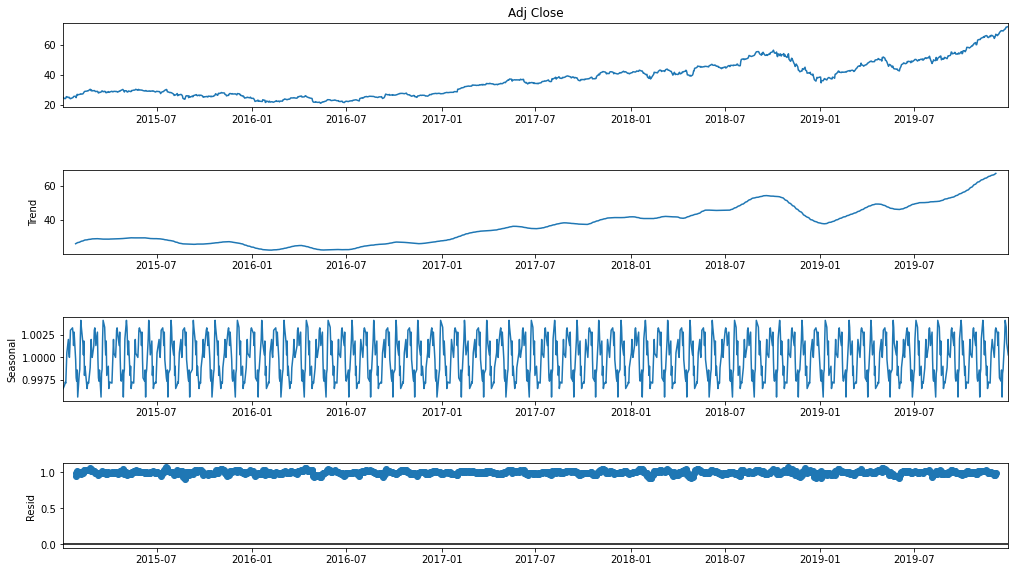

In [32]:
# We see that the p-value is greater than 0.05 so we cannot reject the Null hypothesis. Data is non stationary. 
# We need to separate seasonality and trend
result = seasonal_decompose(df['Adj Close'], model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

In [33]:
# We start by taking a log of the series to reduce the magnitude of the values and reduce the rising trend in the series.

df_log = np.log(df['Adj Close'])

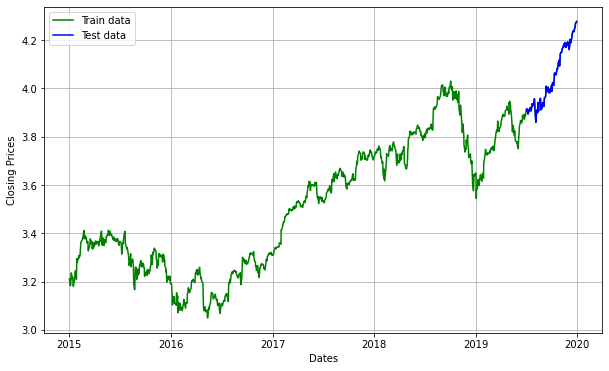

In [34]:
#Now we are going to create an ARIMA model and will train it with the closing price of the stock on the train data. 
#So let us split the data into training and test set and visualize it.

train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [2]:
!pip install pmdarima



     |████████████████████████████████| 1.5MB 4.0MB/s 
     |████████████████████████████████| 9.5MB 17.5MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [35]:
from pmdarima.arima import auto_arima

In [36]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6147.651, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6145.773, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6145.782, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6147.888, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6143.762, Time=1.16 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.979 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1128
Model:               SARIMAX(0, 1, 0)   Log Likelihood                3074.944
Date:                Mon, 12 Jul 2021   AIC                          -6147.888
Time:                        15:06:43   BIC                          -6142.861
Sample:                             0   HQIC                         -6145.989
                               - 1128                                  

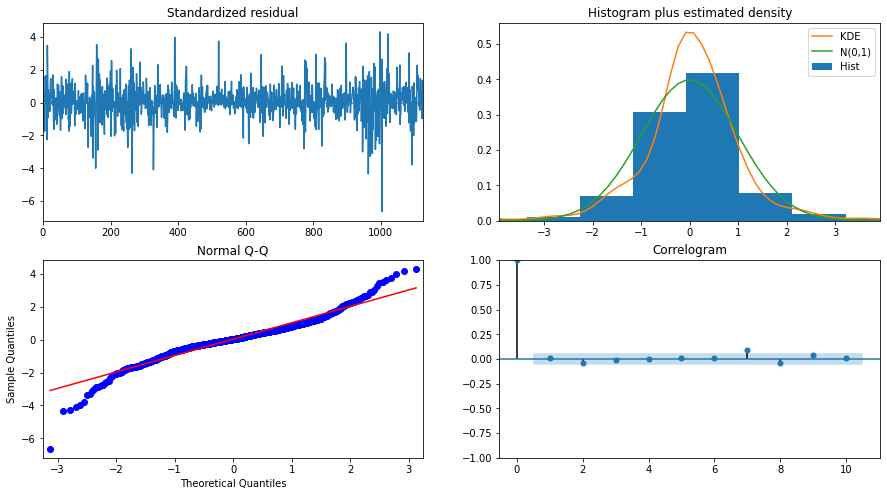

In [39]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [ ]:
#Interpretation

#Top left: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

#Top Right: The density plot suggest normal distribution with mean zero.

#Bottom left: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

#Bottom Right: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.

#Overall, it seems to be a good fit. Let’s start forecasting the stock prices.

In [40]:
#p,d,q values are (0,1,0)
model = ARIMA(train_data, order=(0, 1, 0))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:            D.Adj Close   No. Observations:                 1127
Model:                 ARIMA(0, 1, 0)   Log Likelihood                3075.825
Method:                           css   S.D. of innovations              0.016
Date:                Mon, 12 Jul 2021   AIC                          -6147.651
Time:                        15:10:22   BIC                          -6137.596
Sample:                             1   HQIC                         -6143.851
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000      1.328      0.184      -0.000       0.002


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

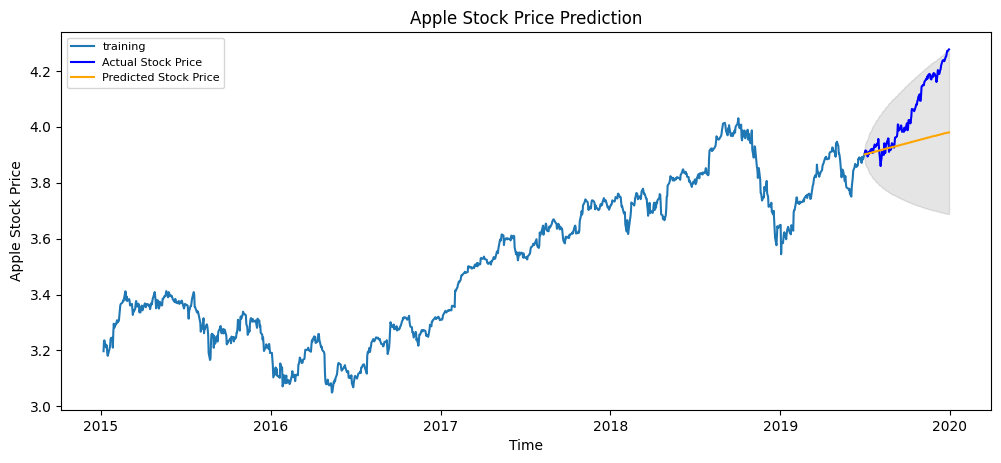

In [50]:
# Forecast
fc, se, conf = fitted.forecast(126, alpha=0.1)  # 90% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Apple Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()


In [52]:
# report performance
mse = mean_squared_error(test_data, fc)
print('Mean Squared Error: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('Mean Absolute Error: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('Root Mean Squared Error: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('Mean Absolute Percentage Error: '+str(mape))

Mean Squared Error: 0.019858845406840044
Mean Absolute Error: 0.10613345779970304
Root Mean Squared Error: 0.14092141571400724
Mean Absolute Percentage Error: 0.025614285076425526


In [53]:
# 2.5% Mean Absolute Percentage Error, therefore model is about 97.5% accurate in predicting the test set observations.